# Conditional Average Treatment Effects (CATE) with DoWhy and EconML

This is an experimental feature where we use [EconML](https://github.com/microsoft/econml) methods from DoWhy. Using EconML allows CATE estimation using different methods. 

All four steps of causal inference in DoWhy remain the same: model, identify, estimate, and refute. The key difference is that we now call econml methods in the estimation step. There is also a simpler example using linear regression to understand the intuition behind CATE estimators. 

All datasets are generated using linear structural equations.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

BETA = 10

In [3]:
data = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                     num_treatments=1,
                                    treatment_is_binary=False,
                                    num_discrete_common_causes=2,
                                    num_discrete_effect_modifiers=0,
                                    one_hot_encode=False)
df=data['df']
print(df.head())
print("True causal estimate is", data["ate"])

         X0        X1   Z0        Z1        W0        W1 W2 W3         v0  \
0  1.025165  1.245504  1.0  0.158014 -0.646130  1.585682  0  2  20.257835   
1 -0.565363 -0.509983  1.0  0.719249 -0.528081 -0.126231  1  1  25.621852   
2 -1.066614  0.258180  1.0  0.117570 -1.291546  1.744535  3  2  21.305156   
3 -1.997311  0.759307  1.0  0.092892  1.002630  1.813077  2  0  15.028699   
4 -0.827012  0.411718  1.0  0.979072 -1.223523 -0.505201  3  2  32.457489   

            y  
0  293.381658  
1  206.815987  
2  204.213489  
3  148.346209  
4  329.822796  
True causal estimate is 11.21529604289463


In [4]:
model = CausalModel(data=data["df"], 
                    treatment=data["treatment_name"], outcome=data["outcome_name"], 
                    graph=data["gml_graph"])

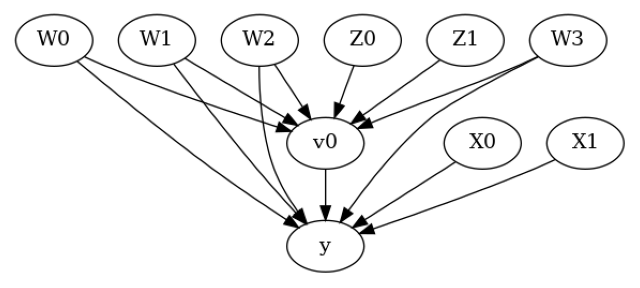

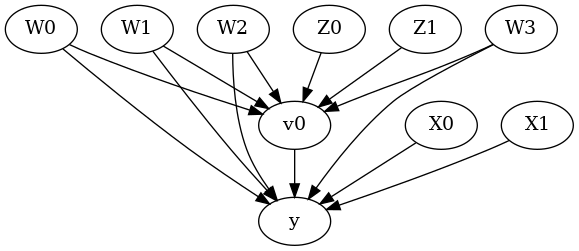

In [5]:
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [6]:
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W0,W2,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W0,W2,W1,U) = P(y|v0,W3,W0,W2,W1)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Linear Model 
First, let us build some intuition using a linear model for estimating CATE. The effect modifiers (that lead to a heterogeneous treatment effect) can be modeled as interaction terms with the treatment. Thus, their value modulates the effect of treatment. 

Below the estimated effect of changing treatment from 0 to 1. 

In [7]:
linear_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="backdoor.linear_regression",
                                       control_value=0,
                                       treatment_value=1)
print(linear_estimate) 

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W0,W2,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W0,W2,W1,U) = P(y|v0,W3,W0,W2,W1)

## Realized estimand
b: y~v0+W3+W0+W2+W1+v0*X0+v0*X1
Target units: ate

## Estimate
Mean value: 11.215317388184836



## EconML methods
We now move to the more advanced methods from the EconML package for estimating CATE.

First, let us look at the double machine learning estimator. Method_name corresponds to the fully qualified name of the class that we want to use. For double ML, it is "econml.dml.DML". 

Target units defines the units over which the causal estimate is to be computed. This can be a lambda function filter on the original dataframe, a new Pandas dataframe, or a string corresponding to the three main kinds of target units ("ate", "att" and "atc"). Below we show an example of a lambda function. 

Method_params are passed directly to EconML. For details on allowed parameters, refer to the EconML documentation. 

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = lambda df: df["X0"]>1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W0,W2,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W0,W2,W1,U) = P(y|v0,W3,W0,W2,W1)

## Realized estimand
b: y~v0+W3+W0+W2+W1 | X0,X1
Target units: Data subset defined by a function

## Estimate
Mean value: 13.400085811212945
Effect estimates: [[14.41337741]
 [13.45208362]
 [ 9.67842125]
 [15.84879707]
 [16.39074825]
 [16.16546261]
 [10.04173632]
 [12.392637  ]
 [16.00831856]
 [13.11585615]
 [14.21585079]
 [13.34411671]
 [13.38717392]
 [10.18190179]
 [ 8.83985949]
 [12.51638494]
 [15.11784384]
 [15.09097619]
 [14.76175268]
 [15.07356089]
 [12.58452803]
 [13.64744088]
 [15.48955572]
 [10.18803306]
 [14.17902343]
 [12.79548303]
 [10.51628739]
 [11.46554612]
 [15.87878077]
 [18.0918523 ]
 [ 8.74436303]
 [14.98557437]
 [15.09756584]
 [15.204

In [9]:
print("True causal estimate is", data["ate"])

True causal estimate is 11.21529604289463


In [10]:
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = 1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W0,W2,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W0,W2,W1,U) = P(y|v0,W3,W0,W2,W1)

## Realized estimand
b: y~v0+W3+W0+W2+W1 | X0,X1
Target units: 

## Estimate
Mean value: 11.197045571286015
Effect estimates: [[14.45970606]
 [ 7.92732219]
 [ 9.21548077]
 ...
 [13.5011984 ]
 [10.93485181]
 [14.24837647]]



### CATE Object and Confidence Intervals
EconML provides its own methods to compute confidence intervals. Using BootstrapInference in the example below. 

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from econml.inference import BootstrapInference
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = "ate",
                                     confidence_intervals=True,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final": LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{
                                                               'inference': BootstrapInference(n_bootstrap_samples=100, n_jobs=-1),
                                                            }
                                              })
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W0,W2,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W0,W2,W1,U) = P(y|v0,W3,W0,W2,W1)

## Realized estimand
b: y~v0+W3+W0+W2+W1 | X0,X1
Target units: ate

## Estimate
Mean value: 11.149665608777859
Effect estimates: [[14.44776338]
 [ 7.89687314]
 [ 9.15672373]
 ...
 [13.46868416]
 [10.87034851]
 [14.22330456]]
95.0% confidence interval: [[[14.47334195  7.77493804  9.08285854 ... 13.49814084 10.85713677
   14.24807635]]

 [[14.75982633  7.99995529  9.23683603 ... 13.72147037 10.99448359
   14.51946201]]]



### Can provide a new inputs as target units and estimate CATE on them.

In [12]:
test_cols= data['effect_modifier_names'] # only need effect modifiers' values
test_arr = [np.random.uniform(0,1, 10) for _ in range(len(test_cols))] # all variables are sampled uniformly, sample of 10
test_df = pd.DataFrame(np.array(test_arr).transpose(), columns=test_cols)
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = test_df,
                                     confidence_intervals=False,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}
                                              })
print(dml_estimate.cate_estimates)

[[12.12394393]
 [11.56905609]
 [12.33823836]
 [12.32042514]
 [10.97170289]
 [12.26657423]
 [12.50776903]
 [11.52478607]
 [12.16132405]
 [12.14057139]]


### Can also retrieve the raw EconML estimator object for any further operations

In [13]:
print(dml_estimate._estimator_object)

## Works with any EconML method
In addition to double machine learning, below we example analyses using orthogonal forests, DRLearner (bug to fix), and neural network-based instrumental variables. 

### Binary treatment, Binary outcome

In [14]:
data_binary = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                    treatment_is_binary=True, outcome_is_binary=True)
# convert boolean values to {0,1} numeric
data_binary['df'].v0 = data_binary['df'].v0.astype(int)
data_binary['df'].y = data_binary['df'].y.astype(int)
print(data_binary['df'])

model_binary = CausalModel(data=data_binary["df"], 
                    treatment=data_binary["treatment_name"], outcome=data_binary["outcome_name"], 
                    graph=data_binary["gml_graph"])
identified_estimand_binary = model_binary.identify_effect(proceed_when_unidentifiable=True)

            X0        X1   Z0        Z1        W0        W1        W2  \
0     0.489904  0.096652  1.0  0.003280 -1.212777  0.358605  0.382168   
1    -0.521101  1.066729  0.0  0.303107 -0.321988  1.705521  0.646738   
2     0.442225 -0.689376  1.0  0.231044  0.140888  1.820693  3.334337   
3    -0.743038 -0.164462  1.0  0.102772  0.230746  1.643060  1.128348   
4     0.734149 -0.261472  1.0  0.531165 -0.288206 -1.385953  0.972841   
...        ...       ...  ...       ...       ...       ...       ...   
9995 -0.525539  1.269989  1.0  0.392007  1.046142  2.115656  2.279879   
9996  0.497916  0.975014  1.0  0.160181 -1.181845 -1.094077  1.543141   
9997 -0.026434 -1.085930  1.0  0.074459  1.233890  0.826205  0.936989   
9998 -0.044771  0.242069  1.0  0.566800  0.337112  0.347759  0.106970   
9999 -0.745530  1.622311  0.0  0.830792  2.201512  0.426812 -0.696532   

            W3  v0  y  
0    -0.582397   1  1  
1     0.824977   1  1  
2     0.394061   1  1  
3     1.140933   1  1  
4  

#### Using DRLearner estimator

In [15]:
from sklearn.linear_model import LogisticRegressionCV
#todo needs binary y
drlearner_estimate = model_binary.estimate_effect(identified_estimand_binary, 
                                method_name="backdoor.econml.dr.LinearDRLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto')
                                                    },
                                               "fit_params":{}
                                              })
print(drlearner_estimate)
print("True causal estimate is", data_binary["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W0,W2,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W0,W2,W1,U) = P(y|v0,W3,W0,W2,W1)

## Realized estimand
b: y~v0+W3+W0+W2+W1 | X0,X1
Target units: ate

## Estimate
Mean value: 0.665623146096894
Effect estimates: [[0.66343849]
 [0.64758808]
 [0.66003439]
 ...
 [0.64998401]
 [0.6538818 ]
 [0.64515619]]

True causal estimate is 0.2493


### Instrumental Variable Method

In [16]:
import keras
dims_zx = len(model.get_instruments())+len(model.get_effect_modifiers())
dims_tx = len(model._treatment)+len(model.get_effect_modifiers())
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_zx,)), # sum of dims of Z and X 
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])                
response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_tx,)), # sum of dims of T and X
                                    keras.layers.Dropout(0.17), 
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(1)])

deepiv_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="iv.econml.iv.nnet.DeepIV",
                                        target_units = lambda df: df["X0"]>-1, 
                                        confidence_intervals=False,
                                method_params={"init_params":{'n_components': 10, # Number of gaussians in the mixture density networks
                                                              'm': lambda z, x: treatment_model(keras.layers.concatenate([z, x])), # Treatment model,
                                                              "h": lambda t, x: response_model(keras.layers.concatenate([t, x])), # Response model
                                                              'n_samples': 1, # Number of samples used to estimate the response
                                                              'first_stage_options': {'epochs':25},
                                                              'second_stage_options': {'epochs':25}
                                                             },
                                               "fit_params":{}})
print(deepiv_estimate)

2023-07-23 17:44:54.124676: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-23 17:44:54.264353: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-23 17:44:54.264398: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-07-23 17:44:59.827010: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-07-23 17:44:59.827073: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to c

Epoch 1/25
313/313 [==============================] - 2s 4ms/step - loss: 8.7182
Epoch 2/25
313/313 [==============================] - 1s 4ms/step - loss: 3.8848
Epoch 3/25
313/313 [==============================] - 1s 4ms/step - loss: 2.7126
Epoch 4/25
313/313 [==============================] - 1s 5ms/step - loss: 2.3840
Epoch 5/25
313/313 [==============================] - 1s 4ms/step - loss: 2.3009
Epoch 6/25
313/313 [==============================] - 1s 3ms/step - loss: 2.2695
Epoch 7/25
313/313 [==============================] - 1s 3ms/step - loss: 2.2531
Epoch 8/25
313/313 [==============================] - 1s 2ms/step - loss: 2.2300
Epoch 9/25
313/313 [==============================] - 1s 3ms/step - loss: 2.2068
Epoch 10/25
313/313 [==============================] - 1s 5ms/step - loss: 2.1900
Epoch 11/25
313/313 [==============================] - 1s 5ms/step - loss: 2.1815
Epoch 12/25
313/313 [==============================] - 1s 4ms/step - loss: 2.1767
Epoch 13/25
313/313 [====

The following Variables were used a Lambda layer's call (lambda_7), but
are not present in its tracked objects:
  <tf.Variable 'dense_3/kernel:0' shape=(3, 128) dtype=float32>
  <tf.Variable 'dense_3/bias:0' shape=(128,) dtype=float32>
  <tf.Variable 'dense_4/kernel:0' shape=(128, 64) dtype=float32>
  <tf.Variable 'dense_4/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'dense_5/kernel:0' shape=(64, 32) dtype=float32>
  <tf.Variable 'dense_5/bias:0' shape=(32,) dtype=float32>
  <tf.Variable 'dense_6/kernel:0' shape=(32, 1) dtype=float32>
  <tf.Variable 'dense_6/bias:0' shape=(1,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


224/224 [==============================] - 0s 2ms/step
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
b: y~v0+W3+W0+W2+W1 | X0,X1
Target units: Data subset defined by a function

## Estimate
Mean value: 1.0939991474151611
Effect estimates: [[ 3.140396 ]
 [-0.9264221]
 [-0.6861267]
 ...
 [ 2.2031708]
 [-0.5570221]
 [ 2.6899872]]



### Metalearners

In [17]:
data_experiment = dowhy.datasets.linear_dataset(BETA, num_common_causes=5, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=5,
                                    treatment_is_binary=True, outcome_is_binary=False)
# convert boolean values to {0,1} numeric
data_experiment['df'].v0 = data_experiment['df'].v0.astype(int)
print(data_experiment['df'])
model_experiment = CausalModel(data=data_experiment["df"], 
                    treatment=data_experiment["treatment_name"], outcome=data_experiment["outcome_name"], 
                    graph=data_experiment["gml_graph"])
identified_estimand_experiment = model_experiment.identify_effect(proceed_when_unidentifiable=True)

            X0        X1        X2        X3        X4   Z0        Z1  \
0     0.129227  0.510094 -1.475240 -0.219903  1.758580  0.0  0.019989   
1     0.129312 -1.265757 -0.927238 -0.617949 -0.526980  0.0  0.533503   
2     1.465955  0.513754  0.600330 -0.991137 -0.343302  1.0  0.041271   
3    -0.848521 -0.300619 -0.219193 -0.796686  0.059552  1.0  0.007219   
4     0.639915  1.777497  0.753570  0.447037  0.221725  0.0  0.246742   
...        ...       ...       ...       ...       ...  ...       ...   
9995  0.993821  0.476915 -1.997253  1.624126 -0.839789  0.0  0.339309   
9996 -0.704006  0.065800  0.758941  1.907440  1.512859  0.0  0.592743   
9997  1.980971  1.174533  0.204603 -0.773177  0.440402  1.0  0.221890   
9998  0.008317 -0.227060  1.315543  0.992438  2.514962  1.0  0.756688   
9999  1.202715  0.530296 -0.650898 -0.748343  1.811226  0.0  0.825335   

            W0        W1        W2        W3        W4  v0          y  
0    -2.455495  0.496016  2.374215  0.096688 -0.784

In [18]:
from sklearn.ensemble import RandomForestRegressor
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'models': RandomForestRegressor()
                                                    },
                                               "fit_params":{}
                                              })
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W3,W4,W0,W2,W1])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W4,W0,W2,W1,U) = P(y|v0,W3,W4,W0,W2,W1)

## Realized estimand
b: y~v0+X3+X1+X2+X0+X4+W3+W4+W0+W2+W1
Target units: ate

## Estimate
Mean value: 15.263186238991091
Effect estimates: [[15.79690208]
 [ 5.37643925]
 [16.59310522]
 ...
 [20.8231476 ]
 [23.31454111]
 [21.81387794]]

True causal estimate is 13.921783106444051


## Avoiding retraining the estimator 

Once an estimator is fitted, it can be reused to estimate effect on different data points. In this case, you can pass `fit_estimator=False` to `estimate_effect`. This works for any EconML estimator. We show an example for the T-learner below.

In [19]:
# For metalearners, need to provide all the features (except treatmeant and outcome)
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                fit_estimator=False,
                                target_units=data_experiment["df"].drop(["v0","y", "Z0", "Z1"], axis=1)[9995:],                        
                                method_params={})
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W3,W4,W0,W2,W1])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W4,W0,W2,W1,U) = P(y|v0,W3,W4,W0,W2,W1)

## Realized estimand
b: y~v0+X3+X1+X2+X0+X4+W3+W4+W0+W2+W1
Target units: Data subset provided as a data frame

## Estimate
Mean value: 18.01798358591133
Effect estimates: [[ 7.2915195 ]
 [23.13507182]
 [12.07144299]
 [27.61115405]
 [19.98072957]]

True causal estimate is 13.921783106444051


## Refuting the estimate

### Adding a random common cause variable

In [20]:
res_random=model.refute_estimate(identified_estimand, dml_estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:11.992439117764018
New effect:12.006660844848646
p value:0.76



### Adding an unobserved common cause variable

In [21]:
res_unobserved=model.refute_estimate(identified_estimand, dml_estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="linear", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:11.992439117764018
New effect:12.024266312057163



### Replacing treatment with a random (placebo) variable

In [22]:
res_placebo=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=10 # at least 100 is good, setting to 10 for speed 
        ) 
print(res_placebo)

             Note: The underlying distribution may not be Normal. We assume that it approaches normal with the increase in sample size.


Refute: Use a Placebo Treatment
Estimated effect:11.992439117764018
New effect:0.01626382750118571
p value:0.3933780406802491



### Removing a random subset of the data

In [23]:
res_subset=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="data_subset_refuter", subset_fraction=0.8,
        num_simulations=10)
print(res_subset)

             Note: The underlying distribution may not be Normal. We assume that it approaches normal with the increase in sample size.


Refute: Use a subset of data
Estimated effect:11.992439117764018
New effect:11.991376826422218
p value:0.4869453171367034



More refutation methods to come, especially specific to the CATE estimators.